### Import all the required libraries 

In [2]:
# Core libraries
from pathlib import Path
import warnings

# Import the basic libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.utils.class_weight import compute_class_weight

try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    SMOTE = None
    warnings.warn("imblearn not available. Install with `pip install imbalanced-learn` to enable SMOTE demos.")

sns.set_theme(style="whitegrid", palette="deep")
pd.options.display.float_format = '{:,.2f}'.format

### Now we need to import the dataset

In [31]:
# Defines the path to the CTG excel file
ctg_path = Path("ctgdata.xlsx")

# Check whether the file exists 
assert ctg_path.exists(), f"Expected Excel file at {ctg_path}"

# Function to read a sheet 
def read_feature_sheet(path: Path, sheet=0):
    """Load the CTG feature sheet, using row 2 as headers and data from row 3 onward."""
    xls = pd.ExcelFile(path)
    if isinstance(sheet, int):
        sheet_name = xls.sheet_names[sheet]
    else:
        sheet_name = sheet
    try:
        df = pd.read_excel(xls, sheet_name=sheet_name, header=1)
    except ValueError:
        df = pd.read_excel(xls, sheet_name=sheet_name, header=0)
    return df



sheet2_raw = read_feature_sheet(ctg_path, sheet=0)


print("Sheets detected:", pd.ExcelFile(ctg_path).sheet_names)
print("Feature sheet shape:", sheet2_raw.shape)

Sheets detected: ['Data']
Feature sheet shape: (2129, 46)


# Data Cleaning

In [33]:
def tidy_sheet(df: pd.DataFrame) -> pd.DataFrame:
    """Drop blank columns/rows, clean names, and deduplicate headers."""
    cleaned = df.copy()
    cleaned.columns = [str(col).strip() for col in cleaned.columns]
    cleaned = cleaned.dropna(axis=0, how='all').dropna(axis=1, how='all')
    cleaned = cleaned.loc[:, ~cleaned.columns.str.contains('^Unnamed', case=False)]
    cleaned = cleaned.loc[:, ~cleaned.columns.duplicated()]
    rename_map = {
        'MSTV': 'mSTV',
        'MLTV': 'mLTV',
        'Variance ': 'Variance',
        'TENDENCY': 'Tendency'
    }
    cleaned = cleaned.rename(columns={k: v for k, v in rename_map.items() if k in cleaned.columns})
    return cleaned


sheet2 = tidy_sheet(sheet2_raw)


target_col = 'NSP'
label_leak_cols = ['CLASS', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP']
label_leak_cols = [col for col in label_leak_cols if col in sheet2.columns]


sheet2.head()

,b,e,AC,FM,UC,DL,DS,DP,DR,LB,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
0,240.00,357.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,120.00,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,1.00,-1.00,9.00,2.00
1,5.00,632.00,4.00,0.00,4.00,2.00,0.00,0.00,0.00,132.00,...,-1.00,-1.00,-1.00,1.00,-1.00,-1.00,-1.00,-1.00,6.00,1.00
2,177.00,779.00,2.00,0.00,5.00,2.00,0.00,0.00,0.00,133.00,...,-1.00,-1.00,-1.00,1.00,-1.00,-1.00,-1.00,-1.00,6.00,1.00
3,411.00,"1,192.00",2.00,0.00,6.00,2.00,0.00,0.00,0.00,134.00,...,-1.00,-1.00,-1.00,1.00,-1.00,-1.00,-1.00,-1.00,6.00,1.00
4,533.00,"1,147.00",4.00,0.00,5.00,0.00,0.00,0.00,0.00,132.00,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,2.00,1.00


## Target Variable
### 1 -> Normal
### 2 -> Suspect
### 3 -> Pathologic

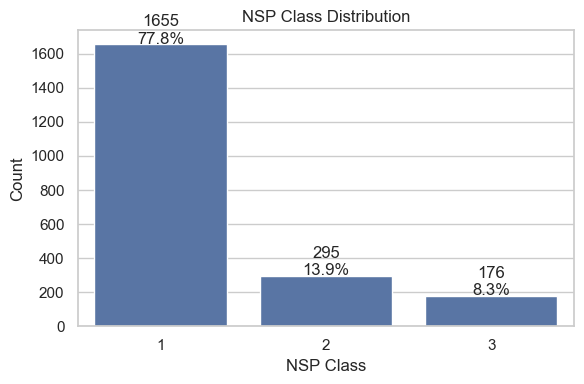

,Class,Count,Proportion
0,1,1655,0.78
1,2,295,0.14
2,3,176,0.08


In [38]:
class_counts = sheet2[target_col].value_counts().sort_index()
class_props = class_counts / class_counts.sum()


fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x=class_counts.index.astype(int), y=class_counts.values, ax=ax)
ax.set_xlabel('NSP Class')
ax.set_ylabel('Count')
ax.set_title('NSP Class Distribution')
for index, value in enumerate(class_counts.values):
    label = f"{value}\n{class_props.iloc[index]:.1%}"
    ax.text(index, value + 5, label, ha='center')
plt.tight_layout()
plt.show()


pd.DataFrame({
    'Class': class_counts.index.astype(int),
    'Count': class_counts.values,
    'Proportion': class_props.values
})

In [40]:
feature_groups = {
    'physiological': ['AC', 'FM', 'UC', 'DL', 'DS', 'DP'],
    'variability': ['ASTV', 'mSTV', 'ALTV', 'mLTV'],
    'histogram': ['Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median', 'Variance', 'Tendency'],
    'timing': ['b', 'e'],
    'baseline': ['LBE', 'LB']
}

available_features = {group: [col for col in cols if col in sheet2.columns]
                      for group, cols in feature_groups.items()}
available_features

{'physiological': ['AC', 'FM', 'UC', 'DL', 'DS', 'DP'],
 'variability': ['ASTV', 'mSTV', 'ALTV', 'mLTV'],
 'histogram': ['Width',
  'Min',
  'Max',
  'Nmax',
  'Nzeros',
  'Mode',
  'Mean',
  'Median',
  'Variance',
  'Tendency'],
 'timing': ['b', 'e'],
 'baseline': ['LB']}

In [42]:
missing_summary = sheet2.isna().sum().sort_values(ascending=False)
missing_summary[missing_summary > 0]

b           2
Width       2
CLASS       2
Tendency    2
Variance    2
Median      2
Mean        2
Mode        2
Nzeros      2
Nmax        2
Max         2
e           2
Min         2
NSP         2
AC          2
AC.1        2
LB          2
LD          1
D           1
C           1
B           1
A           1
FM          1
UC          1
DE          1
SUSP        1
FS          1
AD          1
FM.1        1
UC.1        1
mLTV        1
ALTV        1
mSTV        1
ASTV        1
E           1
dtype: int64

In [44]:
demo_feature = 'ASTV' if 'ASTV' in sheet2.columns else sheet2.select_dtypes(float).columns[0]
demo_df = sheet2[[demo_feature]].copy()
rng = np.random.default_rng(42)
mask_indices = rng.choice(demo_df.index, size=5, replace=False)
demo_df.loc[mask_indices, demo_feature] = np.nan

before_impute = demo_df.loc[mask_indices]
demo_df[demo_feature] = demo_df[demo_feature].fillna(demo_df[demo_feature].median())
after_impute = demo_df.loc[mask_indices]

pd.DataFrame({
    'Index': mask_indices,
    'Before': before_impute.squeeze().values,
    'After': after_impute.squeeze().values
})

,Index,Before,After
0,1644,NaN,49.00
1,933,NaN,49.00
2,1391,NaN,49.00
3,189,NaN,49.00
4,921,NaN,49.00


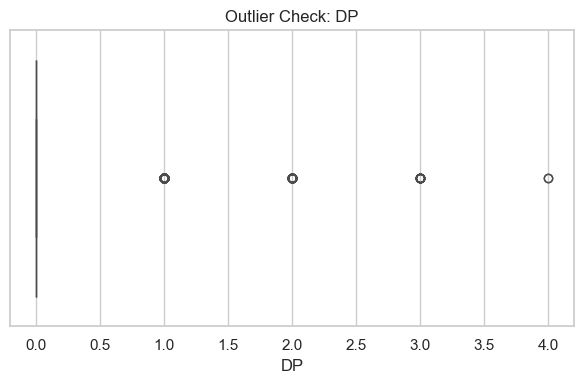

,DP,NSP
5,2.00,3.00
6,2.00,3.00
20,3.00,3.00
22,2.00,3.00
662,2.00,2.00


In [46]:
outlier_feature = 'DP' if 'DP' in sheet2.columns else available_features['physiological'][0]
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(x=sheet2[outlier_feature], ax=ax)
ax.set_title(f'Outlier Check: {outlier_feature}')
plt.tight_layout()
plt.show()

dp_scores = stats.zscore(sheet2[outlier_feature].dropna())
outlier_mask = np.abs(dp_scores) > 3
outlier_indices = sheet2[outlier_feature].dropna().index[outlier_mask]
sheet2.loc[outlier_indices, [outlier_feature, target_col]].head()

In [48]:
sheet2[outlier_feature].value_counts().head()


DP
0.00    1949
1.00     109
2.00      49
3.00      19
4.00       2
Name: count, dtype: int64

In [52]:
duplicate_rows = sheet2.duplicated().sum()
duplicate_rows

10

In [54]:
columns_to_drop = label_leak_cols
print('Dropping label leakage columns:', columns_to_drop)
clean_df = sheet2.drop(columns=columns_to_drop, errors='ignore')
clean_df.head()

Dropping label leakage columns: ['CLASS', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP']


,b,e,AC,FM,UC,DL,DS,DP,DR,LB,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,240.00,357.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,120.00,...,62.00,126.00,2.00,0.00,120.00,137.00,121.00,73.00,1.00,2.00
1,5.00,632.00,4.00,0.00,4.00,2.00,0.00,0.00,0.00,132.00,...,68.00,198.00,6.00,1.00,141.00,136.00,140.00,12.00,0.00,1.00
2,177.00,779.00,2.00,0.00,5.00,2.00,0.00,0.00,0.00,133.00,...,68.00,198.00,5.00,1.00,141.00,135.00,138.00,13.00,0.00,1.00
3,411.00,"1,192.00",2.00,0.00,6.00,2.00,0.00,0.00,0.00,134.00,...,53.00,170.00,11.00,0.00,137.00,134.00,137.00,13.00,1.00,1.00
4,533.00,"1,147.00",4.00,0.00,5.00,0.00,0.00,0.00,0.00,132.00,...,53.00,170.00,9.00,0.00,137.00,136.00,138.00,11.00,1.00,1.00


# Exploratory Data Analysis

## Now I will be conducting exploratory data analysis on the data that has been given to me

In [62]:
# Summary of all the statistics
print(clean_df.describe())

             b        e       AC       FM       UC       DL       DS       DP  \
count 2,126.00 2,126.00 2,126.00 2,127.00 2,127.00 2,128.00 2,128.00 2,128.00   
mean    878.44 1,702.88     2.72     7.50     3.67     1.58     0.00     0.13   
std     894.08   930.92     3.56    39.03     2.88     2.52     0.06     0.47   
min       0.00   287.00     0.00     0.00     0.00     0.00     0.00     0.00   
25%      55.00 1,009.00     0.00     0.00     1.00     0.00     0.00     0.00   
50%     538.00 1,241.00     1.00     0.00     3.00     0.00     0.00     0.00   
75%   1,521.00 2,434.75     4.00     2.00     5.00     3.00     0.00     0.00   
max   3,296.00 3,599.00    26.00   564.00    23.00    16.00     1.00     4.00   

            DR       LB  ...      Min      Max     Nmax   Nzeros     Mode  \
count 2,128.00 2,126.00  ... 2,126.00 2,126.00 2,126.00 2,126.00 2,126.00   
mean      0.00   133.30  ...    93.58   164.03     4.07     0.32   137.45   
std       0.00     9.84  ...    29.56  

In [68]:
# To obtain the data types that are present in the dataset
print(clean_df.dtypes)

b           float64
e           float64
AC          float64
FM          float64
UC          float64
DL          float64
DS          float64
DP          float64
DR          float64
LB          float64
AC.1        float64
FM.1        float64
UC.1        float64
DL.1        float64
DS.1        float64
DP.1        float64
ASTV        float64
mSTV        float64
ALTV        float64
mLTV        float64
Width       float64
Min         float64
Max         float64
Nmax        float64
Nzeros      float64
Mode        float64
Mean        float64
Median      float64
Variance    float64
Tendency    float64
NSP         float64
dtype: object


<Axes: >

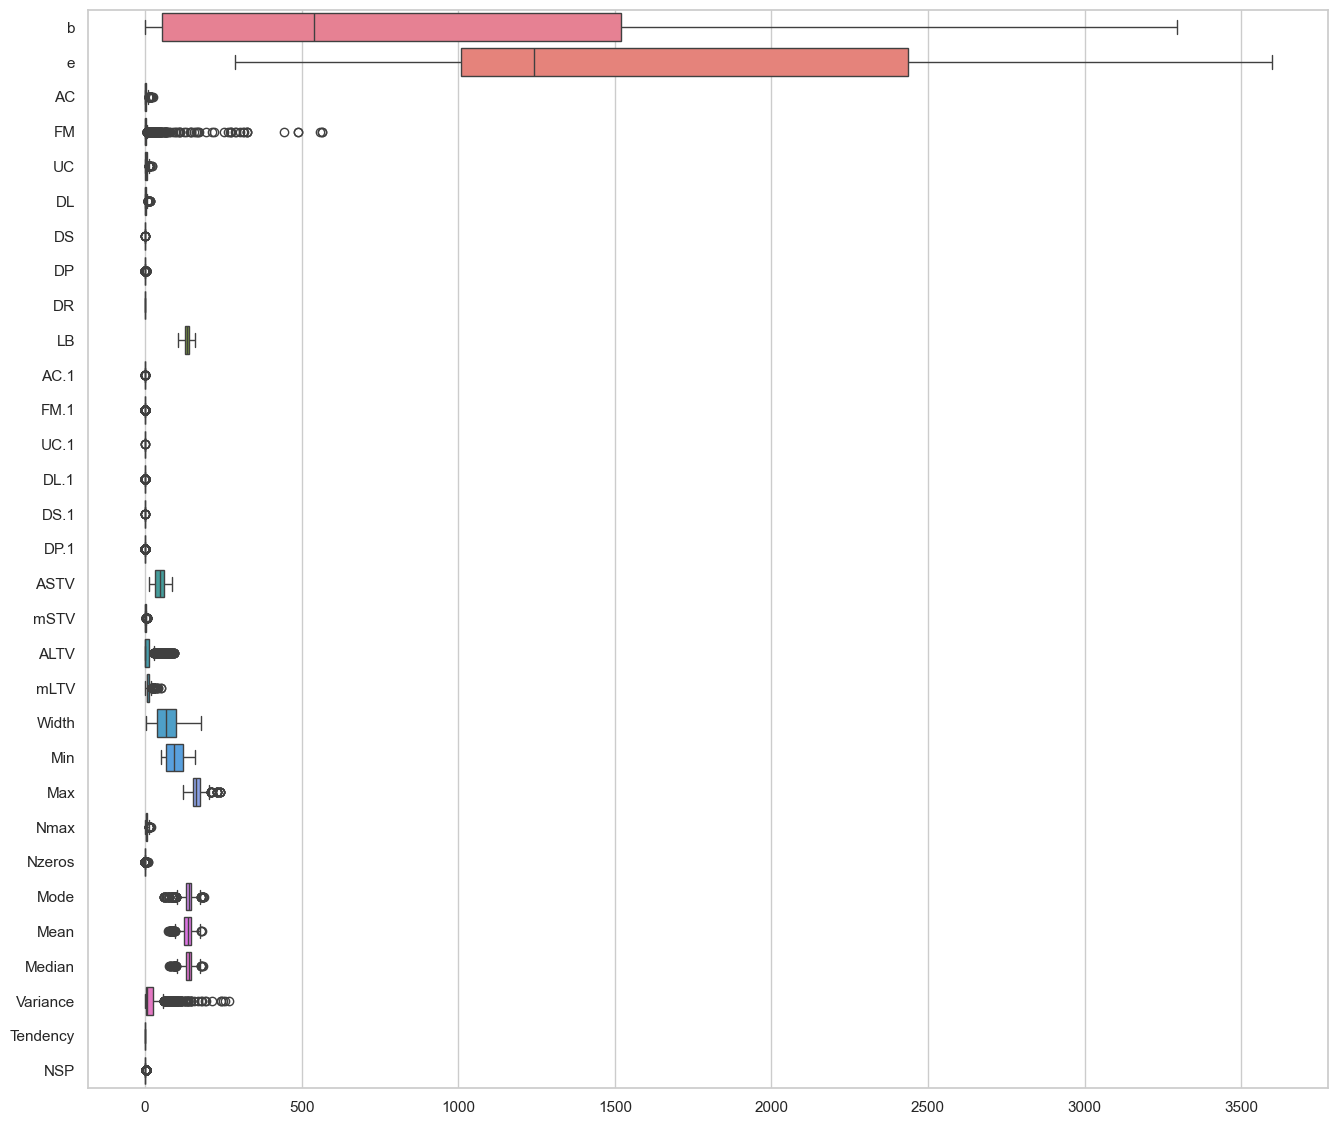

In [72]:
# Draw the Boxplots of all variables
f = plt.figure(figsize=(16, 14))
sns.boxplot(data = clean_df, orient = "h")

Skipped DR: zero variance


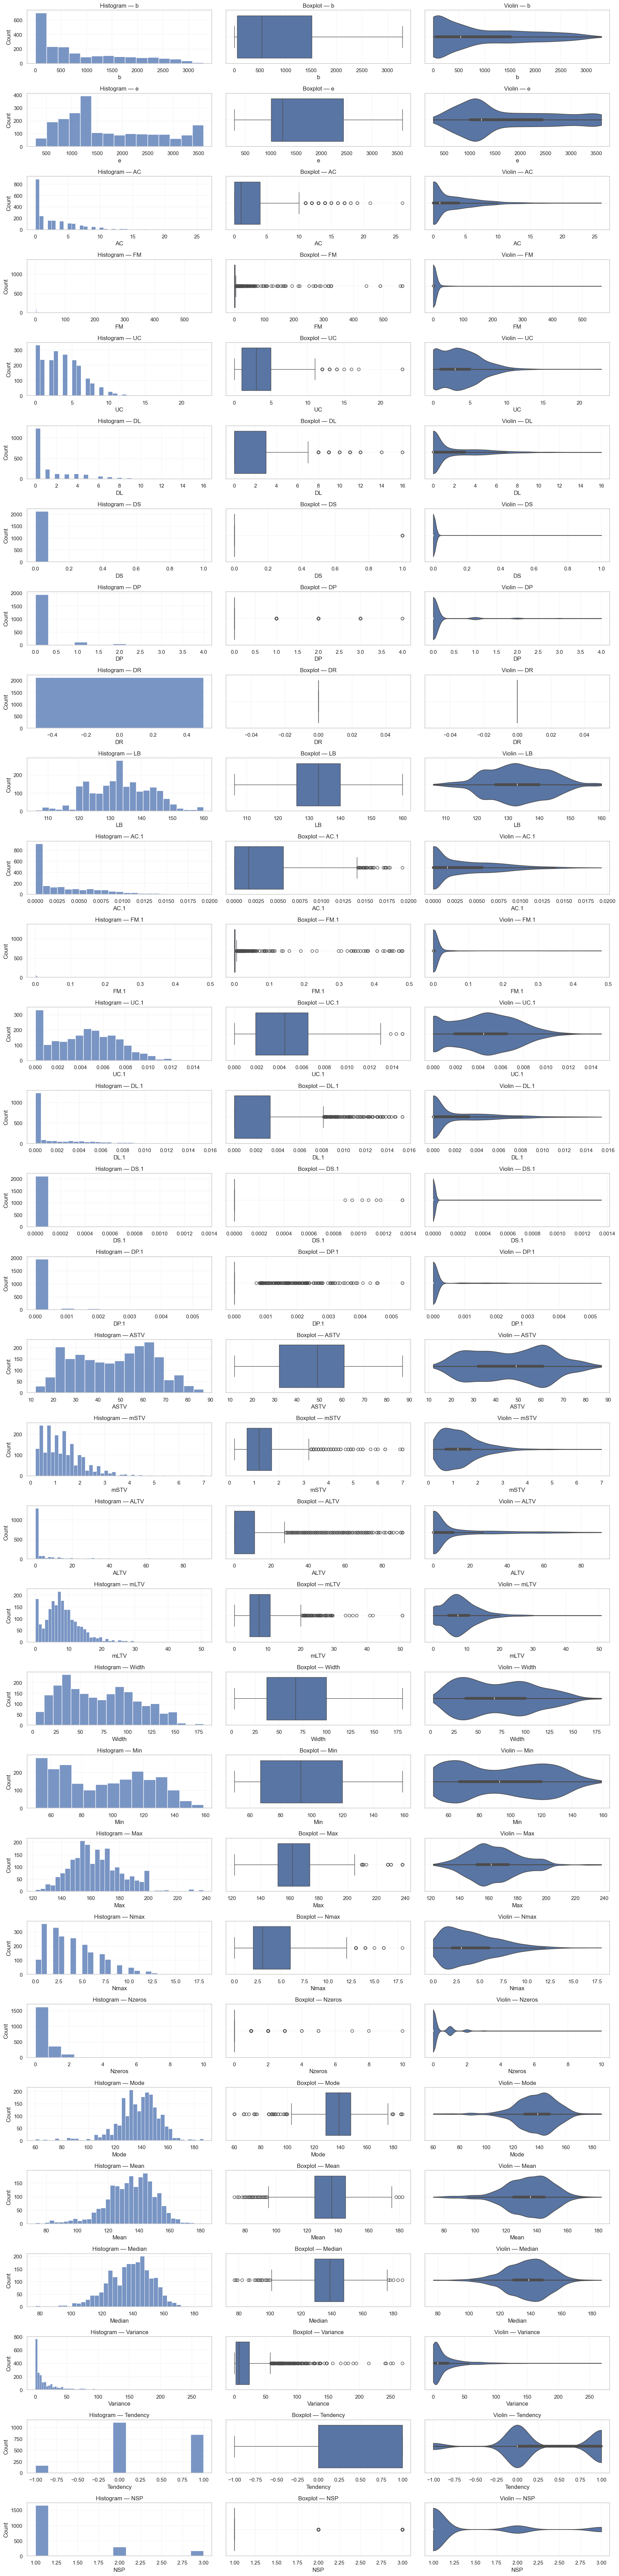

In [86]:
# If your full DF has non-numeric columns, keep only numeric for these plots
num_cols = clean_df.select_dtypes(include=[np.number]).columns.tolist()
n = len(num_cols)

# One row per variable, 3 plots per row
fig, axes = plt.subplots(nrows=n, ncols=3, figsize=(18, max(10, n*2.4)), squeeze=False)

for i, col in enumerate(num_cols):
    # common x-limits per row to align the three plots visually
    xmin, xmax = clean_df[col].min(), clean_df[col].max()

    # 1) Histogram
    sns.histplot(clean_df[col].dropna(), ax=axes[i, 0], bins='auto')
    axes[i, 0].set_title(f'Histogram — {col}')

    # 2) Boxplot (horizontal)
    sns.boxplot(x=clean_df[col], ax=axes[i, 1], orient='h')
    axes[i, 1].set_title(f'Boxplot — {col}')

    # 3) Violin plot (horizontal)
    sns.violinplot(x=clean_df[col], ax=axes[i, 2], orient='h', cut=0)
    axes[i, 2].set_title(f'Violin — {col}')

for col in clean_df.select_dtypes(include=[np.number]).columns:
    if clean_df[col].dropna().nunique() <= 1:
        print(f"Skipped {col}: zero variance")
        continue

# tidy up
for ax in axes.flat:
    ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

In [80]:
# Find the correlations between all the variables within the dataset
clean_df.corr()

,b,e,AC,FM,UC,DL,DS,DP,DR,LB,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
b,1.00,0.94,-0.04,-0.13,0.23,0.09,0.06,0.09,NaN,-0.02,...,0.05,-0.07,-0.07,0.02,-0.03,-0.08,-0.07,0.05,-0.03,-0.11
e,0.94,1.00,0.07,-0.12,0.39,0.16,0.07,0.11,NaN,-0.01,...,0.02,-0.02,-0.03,0.02,-0.02,-0.08,-0.05,0.05,-0.03,-0.12
AC,-0.04,0.07,1.00,0.05,0.21,-0.01,-0.04,-0.11,NaN,-0.08,...,-0.16,0.37,0.19,-0.01,0.22,0.24,0.25,0.11,0.03,-0.34
FM,-0.13,-0.12,0.05,1.00,0.01,0.11,0.10,0.25,NaN,-0.03,...,-0.16,0.11,0.18,-0.01,-0.04,-0.09,-0.06,0.18,-0.00,0.06
UC,0.23,0.39,0.21,0.01,1.00,0.35,0.07,0.17,NaN,-0.13,...,-0.11,0.15,0.10,0.02,-0.08,-0.17,-0.11,0.18,-0.06,-0.16
DL,0.09,0.16,-0.01,0.11,0.35,1.00,0.16,0.31,NaN,-0.16,...,-0.54,0.24,0.39,0.21,-0.32,-0.51,-0.35,0.52,-0.00,0.07
DS,0.06,0.07,-0.04,0.10,0.07,0.16,1.00,0.08,NaN,-0.05,...,-0.07,-0.02,0.01,0.04,-0.22,-0.16,-0.16,0.14,-0.07,0.13
DP,0.09,0.11,-0.11,0.25,0.17,0.31,0.08,1.00,NaN,-0.12,...,-0.29,0.13,0.24,0.05,-0.41,-0.51,-0.45,0.49,-0.21,0.49
DR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LB,-0.02,-0.01,-0.08,-0.03,-0.13,-0.16,-0.05,-0.12,NaN,1.00,...,0.36,0.28,-0.11,-0.00,0.71,0.72,0.79,-0.13,0.29,0.15


<Axes: >

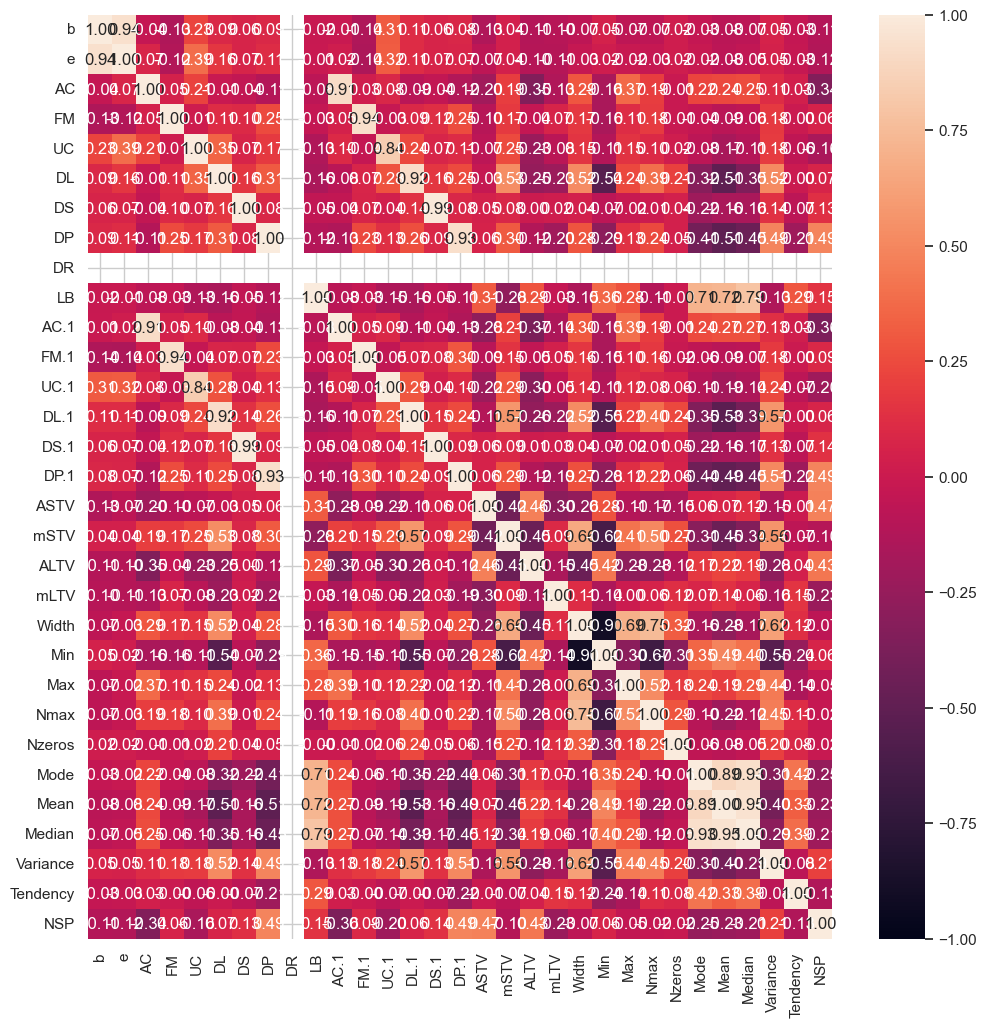

In [84]:
# Heatmap of the Correlation Matrix
f = plt.figure(figsize=(12, 12))
sns.heatmap(clean_df.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

In [96]:
# Compute correlation matrix
corr_matrix = clean_df.corr().abs()  # absolute values, since both + and - strong correlations matter

# Take upper triangle of the correlation matrix (to avoid duplicates & self-correlation = 1.0)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Filter for correlations above 0.6
strong_corr = upper.stack().reset_index()
strong_corr.columns = ['Feature1', 'Feature2', 'Correlation']

# Only keep correlations > 0.6
strong_corr = strong_corr[strong_corr['Correlation'] > 0.6].sort_values(by='Correlation', ascending=False)

print(strong_corr)

    Feature1  Feature2  Correlation
165       DS      DS.1         0.99
425     Mean    Median         0.95
0          b         e         0.94
90        FM      FM.1         0.94
421     Mode    Median         0.93
188       DP      DP.1         0.93
141       DL      DL.1         0.92
63        AC      AC.1         0.91
380    Width       Min         0.90
420     Mode      Mean         0.89
116       UC      UC.1         0.84
221       LB    Median         0.79
382    Width      Nmax         0.75
220       LB      Mean         0.72
219       LB      Mode         0.71
381    Width       Max         0.69
391      Min      Nmax         0.67
346     mSTV     Width         0.66
347     mSTV       Min         0.62
387    Width  Variance         0.62


# Data Analysis of key features in the dataset (AC and DL):

## AC:
### Accelerations in fetal heart rate are a sign of good fetal health as it indicates that the featus is well-oxygenated
### Pathalogic cases often show the lesser of absent accelerations

## DL:
### Light decelerations include small and shallow dips in the heart rate of the fetus and are usually not dangerous 
### Sharp decelerations indicate that the fetus is suddenly losing oxygen and is a red flag
### Prolonged deceleration where the heart rate of the fetus does not bounce back quickly is particularly worrying and often requires intervention

In [93]:
stats_cols = [col for col in ['AC', 'DL'] if col in clean_df.columns]
group_summary = clean_df.groupby(target_col)[stats_cols].agg(['median', 'mean']).round(2)
group_summary

AC          DL     
     median mean median mean
NSP                         
1.00   2.00 3.42   0.00 1.61
2.00   0.00 0.21   0.00 0.40
3.00   0.00 0.33   2.00 3.15

## After analysing the data, I can come to the conclusion:

## NORMAL (1):
### Higher accelerations, Few decelerations

## SUSPECT (2):
### Very low accelerations, Few decelerations 

## PATHALOGIC (3):
### Low accelerations, High number of decelerations

In [99]:
clean_df.describe().T

,count,mean,std,min,25%,50%,75%,max
b,"2,126.00",878.44,894.08,0.00,55.00,538.00,"1,521.00","3,296.00"
e,"2,126.00","1,702.88",930.92,287.00,"1,009.00","1,241.00","2,434.75","3,599.00"
AC,"2,126.00",2.72,3.56,0.00,0.00,1.00,4.00,26.00
FM,"2,127.00",7.50,39.03,0.00,0.00,0.00,2.00,564.00
UC,"2,127.00",3.67,2.88,0.00,1.00,3.00,5.00,23.00
DL,"2,128.00",1.58,2.52,0.00,0.00,0.00,3.00,16.00
DS,"2,128.00",0.00,0.06,0.00,0.00,0.00,0.00,1.00
DP,"2,128.00",0.13,0.47,0.00,0.00,0.00,0.00,4.00
DR,"2,128.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00
LB,"2,126.00",133.30,9.84,106.00,126.00,133.00,140.00,160.00


NSP,1.00,2.00,3.00
LB,,,
NaN,0,0,0
Bradycardic (<110),22,0,6
Normal (110–160),1633,295,170
Tachycardic (>160),0,0,0


NSP,1.00,2.00,3.00
LB,,,
NaN,0.00,0.00,0.00
Bradycardic (<110),0.01,0.00,0.03
Normal (110–160),0.99,1.00,0.97
Tachycardic (>160),0.00,0.00,0.00


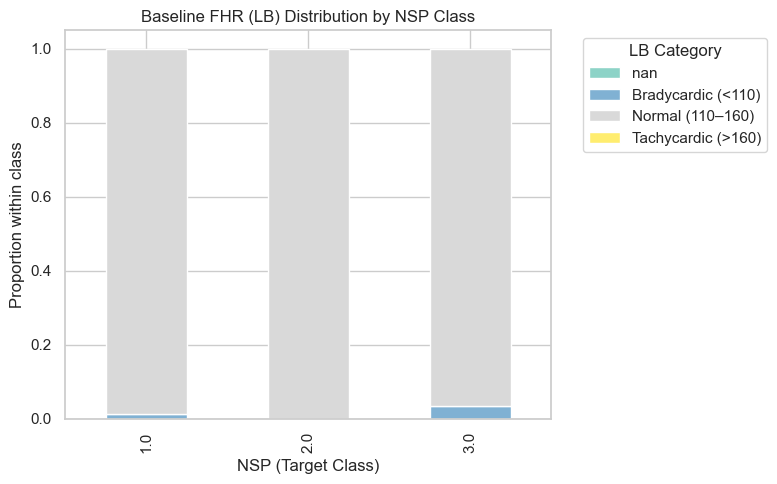

In [121]:
# 1) Bin LB (baseline FHR)
lb_bins = pd.cut(
    clean_df['LB'],
    bins=[0, 110, 160, np.inf],
    labels=['Bradycardic (<110)', 'Normal (110–160)', 'Tachycardic (>160)'],
    include_lowest=True
)

# 2) Crosstab (all rows kept)
lb_ct = pd.crosstab(lb_bins, clean_df[target_col], dropna=False)

# 3) Percentages within each NSP class
lb_pct = lb_ct.div(lb_ct.sum(axis=0), axis=1).round(3)

display(lb_ct)
display(lb_pct)

# 4) Stacked bar chart (percentages)
ax = lb_pct.T.plot(kind='bar', stacked=True, figsize=(8,5), colormap='Set3')
ax.set_title('Baseline FHR (LB) Distribution by NSP Class')
ax.set_xlabel('NSP (Target Class)')
ax.set_ylabel('Proportion within class')
ax.legend(title='LB Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### All the bars are nearly entirely grey. This indicates that almost all of the cases are in the Normal Baseline range. 

### Some blue is present in Class 1 (1%) and Class 3 (2%) which tells me that some of the cases in Normal and Pathologic are Baedycardic

### There is no yellow indicating that there are no cases that are Tachycardic. 

## The spread of the results show me that baseline fetal heart rate (LB) is not a very strong indicator of the NSP class of a particular fetus. More powerful discriminators are required to identify the class of a given LB. 

NSP,1.00,2.00,3.00
ASTV,,,
NaN,0,0,0
<10% (worrisome),0,0,0
10–25% (borderline),294,5,2
>25% (reassuring),1361,290,174


NSP,1.00,2.00,3.00
ASTV,,,
NaN,0.00,0.00,0.00
<10% (worrisome),0.00,0.00,0.00
10–25% (borderline),0.18,0.02,0.01
>25% (reassuring),0.82,0.98,0.99


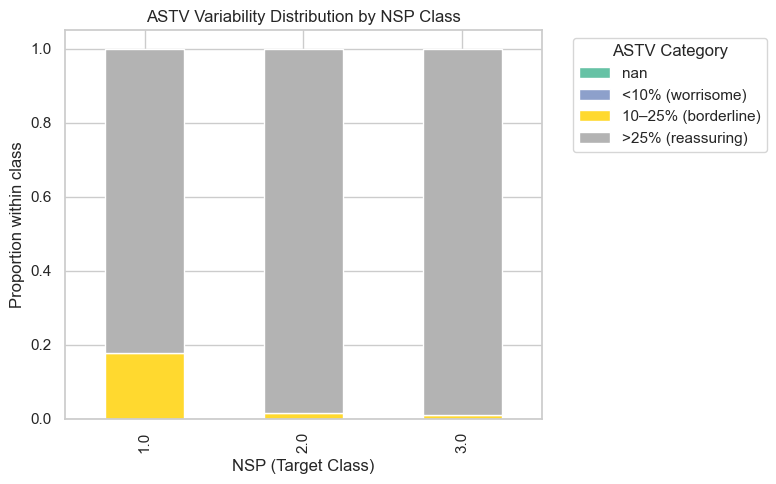

In [123]:
# 1) Bin ASTV
astv_bins = pd.cut(
    clean_df['ASTV'],
    bins=[0, 10, 25, np.inf],
    labels=['<10% (worrisome)', '10–25% (borderline)', '>25% (reassuring)'],
    include_lowest=True
)

# 2) Crosstab (all rows kept)
astv_ct = pd.crosstab(astv_bins, clean_df[target_col], dropna=False)

# 3) Percentages within each NSP class
astv_pct = astv_ct.div(astv_ct.sum(axis=0), axis=1).round(3)

display(astv_ct)
display(astv_pct)

# 4) Stacked bar chart (percentages)
ax = astv_pct.T.plot(kind='bar', stacked=True, figsize=(8,5), colormap='Set2')
ax.set_title('ASTV Variability Distribution by NSP Class')
ax.set_xlabel('NSP (Target Class)')
ax.set_ylabel('Proportion within class')
ax.legend(title='ASTV Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### The bars are almost entirely grey (>25% reassuring).
### Only the Normal class shows a visible yellow portion (10–25% borderline, ~18%).
### Suspect and Pathologic are nearly 100% in the reassuring category.
### There is no blue present which indicates that none of the data was worrisome

## The spread of the results show me that ASTV is not a very strong indicator of the NSP class of a particular fetus. More powerful discriminators are required to identify the class of a given ASTV.

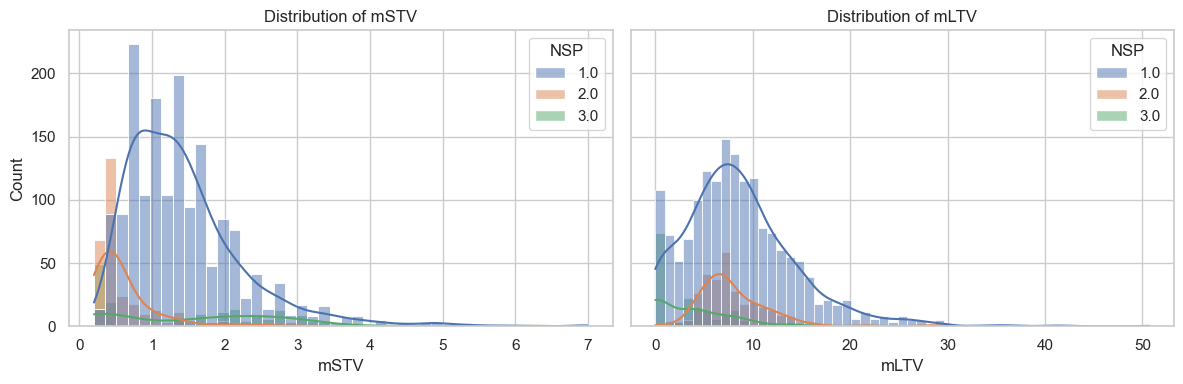

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
for ax, feature in zip(axes, ['mSTV', 'mLTV']):
    if feature not in clean_df.columns:
        ax.set_visible(False)
        continue
    sns.histplot(data=clean_df, x=feature, hue=target_col, kde=True,
                 common_norm=False, ax=ax, palette='deep')
    ax.set_title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

## When analysing the means short term variability (mSTV)

### NSP = 1 : Peaks at around 1
### NSP = 2 : Peaks between 0 and 1
### NSP = 3 : Peaks at 0

### Normal cases generally have a higher mSTV, followed by Suspect cases and Pathalogic cases have the lowest mSTV. 

## When analysing the means long term variability (mLTV)

### NSP = 1 : Peaks around 10
### NSP = 2 : Peaks between 5 & 10
### NSP = 3 : Peaks around 0-5

### Normal cases generally have a higher mLTV, followed by Suspect cases and Pathologic cases have the lowest mLTV.

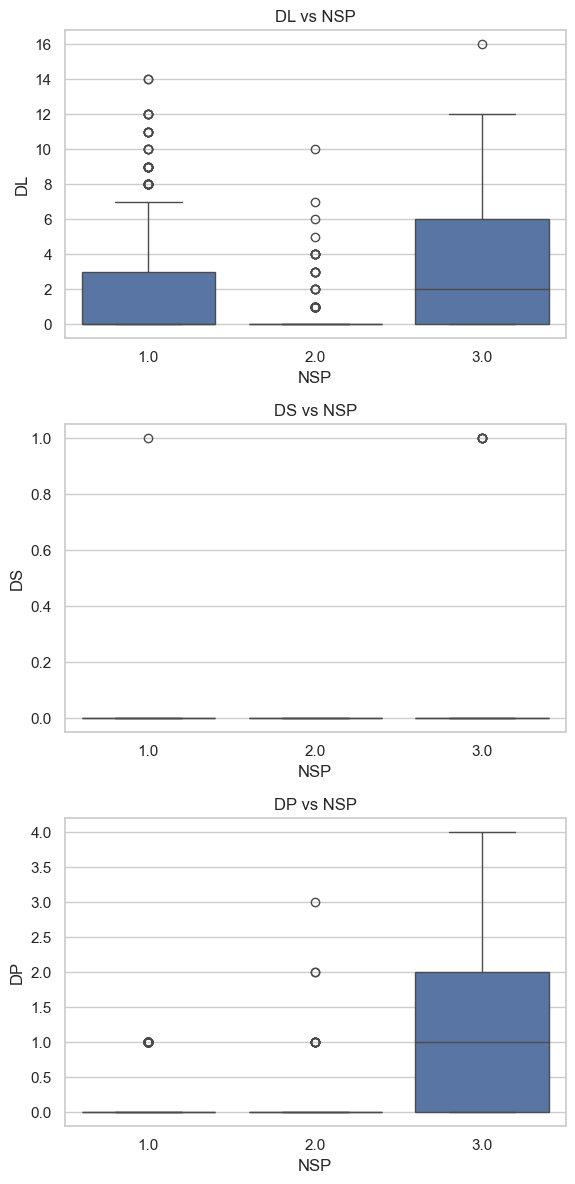

In [130]:
# Plot the boxplots of the deceleration features
box_features = [col for col in ['DL', 'DS', 'DP'] if col in clean_df.columns]
plt.figure(figsize=(6, 4 * len(box_features)))
for idx, feature in enumerate(box_features, start=1):
    ax = plt.subplot(len(box_features), 1, idx)
    sns.boxplot(data=clean_df, x=target_col, y=feature, ax=ax)
    ax.set_title(f'{feature} vs NSP')
plt.tight_layout()
plt.show()

## Light Deceleration vs NSP (DL vs NSP)

### NSP = 1 : Low median with a narrow spread
### NSP = 2 : Almost NULL values
### NSP = 3 : High median with a wider spread

### From this data, I can conclude that light decelerations are generally found more in Pathologic cases.

## Severe Deceleration vs NSP (DS vs NSP)

### Most of the columns DS are NULL. DS are rare in this dataset and cannot be solely used to predict NSP.

## Prolonged Deceleration vs NSP (DP vs NSP)

### NSP = 1 : Almost no cases
### NSP = 2 : Almost no cases
### NSP = 3 : High median with a wider spread

### From this data, I can conclude that prolonged decelerations are able to strongly indicate Pathologic cases. 

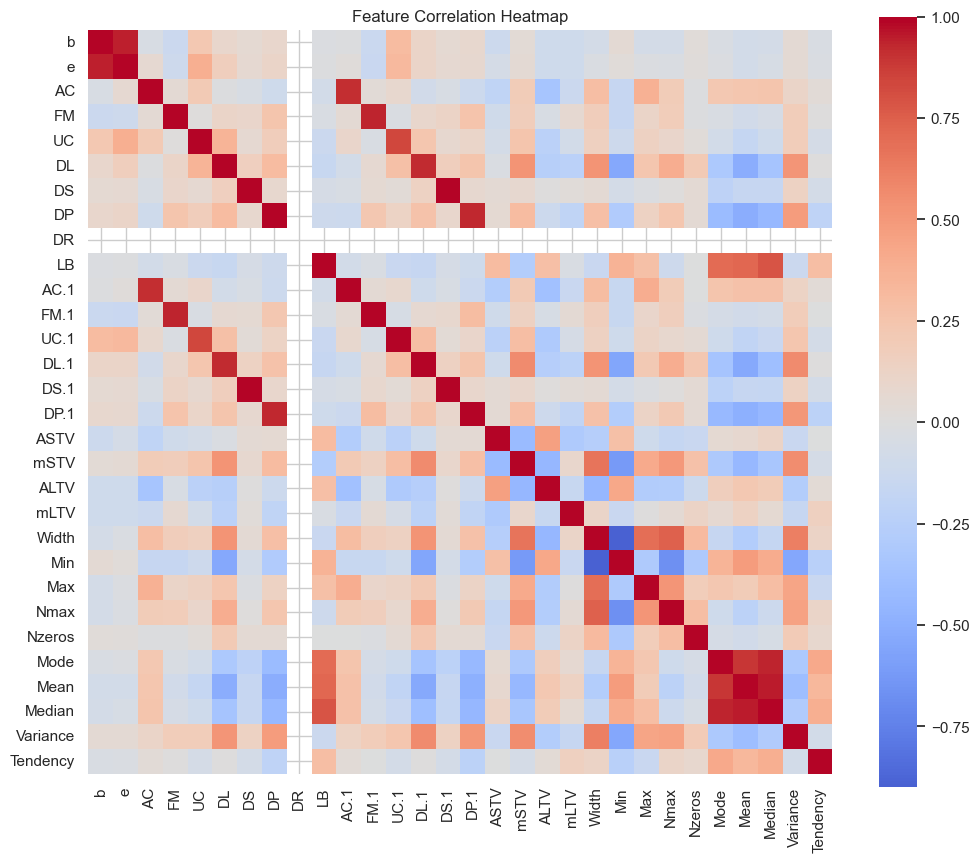

DS     DS.1     0.99
Mean   Median   0.95
b      e        0.94
FM     FM.1     0.94
Mode   Median   0.93
DP     DP.1     0.93
DL     DL.1     0.92
AC     AC.1     0.91
Width  Min      0.90
Mode   Mean     0.89
dtype: float64

In [137]:
# Create a correlation heatmap for all the features 
corr_features = clean_df.select_dtypes(include=[np.number]).drop(columns=[target_col])
corr_matrix = corr_features.corr(method='pearson')
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True)
plt.title('Feature Correlation Heatmap')
plt.show()

# Extract the top 10 correlations 
corr_pairs = corr_matrix.abs().where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
corr_pairs.stack().sort_values(ascending=False).head(10)

In [139]:
corr_features = clean_df.select_dtypes(include=[np.number]).drop(columns=[target_col])

# filter out columns with zero or near-zero variance
non_constant_cols = corr_features.columns[corr_features.nunique() > 1]
corr_features = corr_features[non_constant_cols]

anova_results = []
for feature in corr_features.columns:
    groups = [vals.dropna().values for _, vals in clean_df.groupby(target_col)[feature]]
    if len([g for g in groups if len(g) > 0]) < 2:
        continue
    try:
        h_stat, p_value = stats.kruskal(*groups)
        anova_results.append((feature, h_stat, p_value))
    except ValueError:
        # handles any remaining pathological cases
        continue

anova_df = (pd.DataFrame(anova_results, columns=['Feature', 'H-statistic', 'p-value'])
              .sort_values('H-statistic', ascending=False))
anova_df.head(10)

,Feature,H-statistic,p-value
14,DP.1,541.94,0.00
7,DP,538.48,0.00
15,ASTV,533.44,0.00
17,ALTV,496.07,0.00
9,AC.1,452.92,0.00
2,AC,450.98,0.00
16,mSTV,383.31,0.00
25,Mean,302.79,0.00
26,Median,293.63,0.00
24,Mode,268.72,0.00


# Currently, there are many features within the dataset and we are trying to find out which features actually differ between the target groups. 

# If a feature looks similar acriss all the NSPs, it is not useful. However, if a feature is different across classes, it is informative.

## Kruskal-Wallis allows me to quantify group differences
### High H-statistic = strong separation -> important features
### Low H-statistic = weak separation -> probably noise

### Kruskal-Wallis is able to rank the features by its discriminative power. 

In [142]:
corr_features = clean_df.select_dtypes(include=[np.number]).drop(columns=[target_col])

# filter out columns with zero or near-zero variance
non_constant_cols = corr_features.columns[corr_features.nunique() > 1]
corr_features = corr_features[non_constant_cols]

anova_results = []
for feature in corr_features.columns:
    groups = [vals.dropna().values for _, vals in clean_df.groupby(target_col)[feature]]
    if len([g for g in groups if len(g) > 0]) < 2:
        continue
    try:
        h_stat, p_value = stats.kruskal(*groups)
        anova_results.append((feature, h_stat, p_value))
    except ValueError:
        # handles any remaining pathological cases
        continue

anova_df = (pd.DataFrame(anova_results, columns=['Feature', 'H-statistic', 'p-value'])
              .sort_values('H-statistic', ascending=False))
anova_df.head(10)

,Feature,H-statistic,p-value
14,DP.1,541.94,0.00
7,DP,538.48,0.00
15,ASTV,533.44,0.00
17,ALTV,496.07,0.00
9,AC.1,452.92,0.00
2,AC,450.98,0.00
16,mSTV,383.31,0.00
25,Mean,302.79,0.00
26,Median,293.63,0.00
24,Mode,268.72,0.00


## From the results of the Kruskal-Wallis test, the top discriminators of fetal state are:

### DP & DP.1 : Prolonged Deceleration
### ASTV : Short Term Variability 
### ALTV : Long Term Variability 
### AC.1 & AC : Acceleration 

### Mean, Median & Mode are weaker discriminators of fetal state

## The dataset that is being used to predict fetal stress reliably.

## The target variable has 3 classes 
### Normal (1) : thousands of samples (80% of the dataset)
### Suspect (2) : few hundred samples (15% of the dataset)
### Pathologic (3) : very rare (5% of the dataset)

## Since most of the samples are under the Normal class, if the model predicts "Normal", it will be right most of the time as it will have an accuracy of 80%. 

## In our case, we are trying to predict the rare but extremely dangerous Pathologic Case. Since a naive model would want to maximise accuracy, it will tend to choose the majority class. This leads to the class imbalance problem. 

# It is essential for the target (NSP) to be prepared for machine learning and therefore be able to handle the class imbalance. 

In [147]:
# 1. Inspect the target column
clean_df[target_col].value_counts(dropna=False)
clean_df[target_col].unique()

# 2. Drop or impute missing labels
y = clean_df[target_col]

# Option A – drop rows with missing NSP values
mask = y.notna()
y = y.loc[mask]

# Optionally keep the aligned feature matrix if needed later
# X = clean_df.loc[mask, feature_cols]

# 3. Make sure the dtype is consistent (integers)
y = y.astype(int)

# 4. Recompute classes and weights
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced',
                               classes=classes,
                               y=y)

class_weight_dict = dict(zip(classes, weights))
class_weight_dict


{1: 0.4281973816717019, 2: 2.4022598870056497, 3: 4.026515151515151}

### The values assigned to each of the class indicates the weights assigned to each class. 

### Class 1 : 0.43
### This class is a majority class. Its weight is small so the model will not overfocus on it. 

### Class 2 : 2.40
### This class is less common than Normal. Its weight is higher and the model will pay 5 times more attention to it compared to Normal.

### Class 3: 4.03
### This class is the least common. Its weight is the highest and the model will pay 10 times more attention to it compared to Normal. 

# Many ML models work better if it is on a comparable scale. 
## After scaling, each column will have a mean of around 0 and standardisation of around 1

In [151]:
scale_features = [col for col in ['AC', 'ASTV'] if col in clean_df.columns]
scale_sample = clean_df[scale_features].sample(n=5, random_state=0)
scaler = StandardScaler()
scaled_values = scaler.fit_transform(scale_sample)
scaled_df = pd.DataFrame(scaled_values, columns=[f'{col}_scaled' for col in scale_features], index=scale_sample.index)
pd.concat([scale_sample, scaled_df], axis=1)

,AC,ASTV,AC_scaled,ASTV_scaled
563,1.00,30.00,-0.56,-1.52
759,0.00,66.00,-1.12,1.08
1668,3.00,63.00,0.56,0.87
847,1.00,40.00,-0.56,-0.80
1784,5.00,56.00,1.68,0.36


# SMOTE = Synthetic Minority Over-sampling Technique.

## It creates synthetic points for minority classes by taking each minority sample, finding its k-nearest neighbors in feature space, and interpolating between them.

In [155]:
feature_cols = [col for col in clean_df.columns if col != target_col]
y = clean_df[target_col].dropna().astype(int)
X = clean_df.loc[y.index, feature_cols]

# Median-impute any residual NaNs so SMOTE has a dense matrix to work with
X_imputed = X.fillna(X.median(numeric_only=True))

if SMOTE is not None:
    smote = SMOTE(random_state=42, sampling_strategy='not majority')
    X_resampled, y_resampled = smote.fit_resample(X_imputed, y)
    print('Original shape:', X.shape, y.value_counts().to_dict())
    print('Resampled shape:', X_resampled.shape, pd.Series(y_resampled).value_counts().to_dict())
else:
    print('SMOTE unavailable. Consider installing imbalanced-learn for oversampling demos.')

Original shape: (2126, 30) {1: 1655, 2: 295, 3: 176}
Resampled shape: (4965, 30) {2: 1655, 1: 1655, 3: 1655}


### The original shape was extrememly unbalanced. However after SMOTE, all three classes are perfectly balanced. 

### Now the dataset is balanced and the model will not be biased to predicting "Normal" all the time. This will improve the recall for the rarer Suspect and Pathalogic cases. 

# The Chi-squared test can be conducted to find out which features are strongly associated with the target features (NSP).

In [159]:
mask = clean_df[target_col].notna()
y = clean_df.loc[mask, target_col].astype(int)
numeric_features = clean_df.select_dtypes(include=[np.number]).columns.drop(target_col)
X_numeric = clean_df.loc[mask, numeric_features].fillna(clean_df[numeric_features].median())
minmax = MinMaxScaler()
X_scaled = minmax.fit_transform(X_numeric)
selector = SelectKBest(score_func=chi2, k=10)
selector.fit(X_scaled, y)
selected_scores = pd.Series(selector.scores_, index=numeric_features).sort_values(ascending=False)
selected_scores.head(15)

DP         306.22
DP.1       282.01
ALTV       196.94
AC.1        80.84
ASTV        58.56
DS          55.31
AC          51.98
DS.1        47.53
Variance    43.87
DL.1        39.10
DL          33.65
Min         29.72
UC.1        23.15
mSTV        21.84
b           19.25
dtype: float64

### The higher the score, the more strongly that feature is associated with the target variable (NSP)

## Form the results, the top features are:
### DP & DP.1 (Prolonged deceleration)
### ALTV (Abnormal Long Term Variability)
### AC.1 (Acceleration)
### ASTV (Abnornal Short Term Variability)
### DS & DS.1 (Severe Deceleration)

### These features tells us which CTG features are more statistically associated with with fetal outcome. 

# Principal Component Analysis (PCA)

## It takes a dataset with many features (like your 30 CTG parameters) and finds a smaller number of “principal components” that:

### capture most of the variance (information) in the data

### while being uncorrelated (no redundancy).

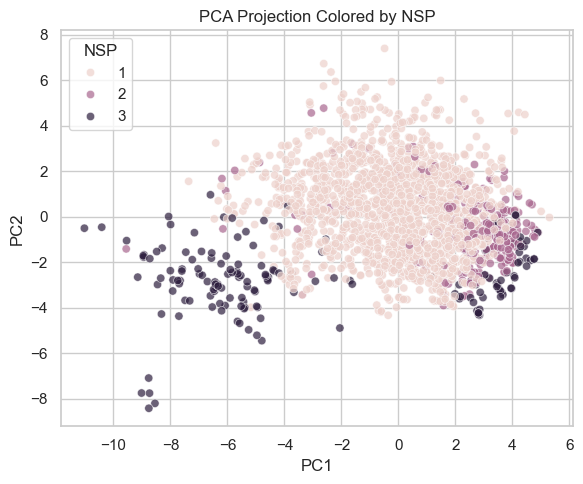

array([0.24173657, 0.13586564])

In [165]:
pca = PCA(n_components=2, random_state=42)
X_scaled_std = StandardScaler().fit_transform(X_numeric)
pca_components = pca.fit_transform(X_scaled_std)
pca_df = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])
pca_df[target_col] = y.values

plt.figure(figsize=(6, 5))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue=target_col, alpha=0.7)
plt.title('PCA Projection Colored by NSP')
plt.tight_layout()
plt.show()

pca.explained_variance_ratio_

## Upon analysing the results:
### Class 1 forms a big cluster
### Class 3 lies far away
### Class 2 overlaps with the other classes

# K-means clustering allows the dataset to organise itself into categories based on similarity

In [170]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(X_scaled_std)
cluster_vs_nsp = pd.crosstab(cluster_labels, y, normalize='index').round(2)
cluster_vs_nsp

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


NSP,1,2,3
row_0,,,
0,0.70,0.24,0.06
1,0.32,0.07,0.62
2,0.97,0.03,0.00


# Analysing the results:

## Cluster 0: 
### 70% Normal, 24% Suspect, 6% Pathalogic
### This cluster is majority Normal with some overlap with Suspect 

## Cluster 1:
### 32% Normal, 7% Suspect, 62% Pathalogic
### This cluster is majority Pathologic with some overlap with Normal 

## Cluster 2:
### 97% Normal, 3% Suspect, 0% Pathalogic
### Majority Normal

### There are two strong clusters -> these two groups are distinct within the dataset
### Suspect does not form its own clean cluster. Instead, it overlaps heavily with Normal and Pathologic. This makes it clear on why the model may misclassify "Suspect", mainly due to the ambiguity of the data.

# Train/Test Split

In [174]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print('Train shape:', X_train.shape)
print('Test shape:', X_test.shape)

pd.DataFrame({
    'Split': ['Train', 'Test'],
    'Normal (1)': [np.mean(y_train == 1), np.mean(y_test == 1)],
    'Suspect (2)': [np.mean(y_train == 2), np.mean(y_test == 2)],
    'Pathologic (3)': [np.mean(y_train == 3), np.mean(y_test == 3)]
}).rename(columns=lambda c: c if c == 'Split' else f'{c} proportion')

Train shape: (1488, 30)
Test shape: (638, 30)


,Split,Normal (1) proportion,Suspect (2) proportion,Pathologic (3) proportion
0,Train,0.78,0.14,0.08
1,Test,0.78,0.14,0.08


In [180]:
# Core libraries and model APIs
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score, f1_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

sns.set_theme(style="whitegrid", palette="deep")
pd.options.display.float_format = '{:,.2f}'.format

In [184]:
# Load and tidy the engineered feature sheet
ctg_path = Path("ctgdata.xlsx")
assert ctg_path.exists(), f"Expected Excel file at {ctg_path.resolve()}"

def read_feature_sheet(path: Path, sheet=0):
    """Load the CTG feature sheet, using row 2 as headers and data from row 3 onward."""
    xls = pd.ExcelFile(path)
    sheet_name = xls.sheet_names[sheet] if isinstance(sheet, int) else sheet
    try:
        df = pd.read_excel(xls, sheet_name=sheet_name, header=1)
    except ValueError:
        df = pd.read_excel(xls, sheet_name=sheet_name, header=0)
    return df

raw_features = read_feature_sheet(ctg_path, sheet=0)
raw_features.shape

(2129, 46)

In [186]:
# Clean columns, drop leakage, and ensure numerics
def tidy_sheet(df: pd.DataFrame) -> pd.DataFrame:
    cleaned = df.copy()
    cleaned.columns = [str(col).strip() for col in cleaned.columns]
    cleaned = cleaned.dropna(axis=0, how='all').dropna(axis=1, how='all')
    cleaned = cleaned.loc[:, ~cleaned.columns.str.contains('^Unnamed', case=False)]
    cleaned = cleaned.loc[:, ~cleaned.columns.duplicated()]
    rename_map = {
        'MSTV': 'mSTV',
        'MLTV': 'mLTV',
        'Variance ': 'Variance',
        'TENDENCY': 'Tendency'
    }
    cleaned = cleaned.rename(columns={k: v for k, v in rename_map.items() if k in cleaned.columns})
    return cleaned

sheet2 = tidy_sheet(raw_features)
target_col = 'NSP'
label_leak_cols = ['CLASS', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP']
feature_cols = [col for col in sheet2.columns if col not in label_leak_cols + [target_col]]
clean_df = (
    sheet2
    .drop(columns=label_leak_cols, errors='ignore')
    .dropna(axis=0, how='all')
    .drop_duplicates()
)

# Coerce numeric columns and drop rows without labels
numeric_cols = feature_cols
clean_df[numeric_cols] = clean_df[numeric_cols].apply(pd.to_numeric, errors='coerce')
clean_df = clean_df.dropna(subset=[target_col]).copy()
clean_df[target_col] = clean_df[target_col].astype(int)

X = clean_df[numeric_cols]
y = clean_df[target_col]
X.shape, y.value_counts().sort_index()

((2115, 30),
 NSP
 1    1647
 2     293
 3     175
 Name: count, dtype: int64)

In [188]:
# Stratified train/test split and class weights
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
classes = np.unique(y_train)
class_weight_values = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weight_values))
sample_weight_train = compute_sample_weight(class_weight='balanced', y=y_train)

distribution = (
    pd.DataFrame({
        'Split': ['Train', 'Test'],
        'Size': [len(y_train), len(y_test)],
        'Normal (1)': [np.mean(y_train == 1), np.mean(y_test == 1)],
        'Suspect (2)': [np.mean(y_train == 2), np.mean(y_test == 2)],
        'Pathologic (3)': [np.mean(y_train == 3), np.mean(y_test == 3)]
    })
    .rename(columns=lambda c: c if c in {'Split', 'Size'} else f'{c} proportion')
)
distribution, class_weight_dict

(   Split  Size  Normal (1) proportion  Suspect (2) proportion  \
 0  Train  1480                   0.78                    0.14   
 1   Test   635                   0.78                    0.14   
 
    Pathologic (3) proportion  
 0                       0.08  
 1                       0.08  ,
 {1: 0.4278693263949118, 2: 2.4065040650406506, 3: 4.043715846994536})

In [192]:
# Shared evaluation helper
results = []

def evaluate_model(name, estimator, X_train, y_train, X_test, y_test, fit_kwargs=None, display_report=False):
    fit_kwargs = fit_kwargs or {}
    estimator.fit(X_train, y_train, **fit_kwargs)
    y_pred = estimator.predict(X_test)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    results.append({'Model': name, 'Balanced Accuracy': bal_acc, 'F1 Macro': f1})
    print(f"{name} — Balanced Accuracy: {bal_acc:.3f}, Macro F1: {f1:.3f}")
    if display_report:
        print(classification_report(y_test, y_pred, digits=3))
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, display_labels=sorted(classes), normalize='true', cmap='Blues'
    )
    disp.ax_.set_title(f"{name} — Normalized Confusion Matrix")
    plt.show()
    return estimator, y_pred

classes

array([1, 2, 3])

# LOGISTIC REGRESSION

## Optimises a multinomial logistic loss to find weights that maximise the likelihood of observed labels, effectively fitting linear decision boundaries in feature space.

## Converts weighted sums into caluberated class probabilities via the logistic (softmax) function, giving interpretable coefficients. 

## Decision boundary is a hyperplane; regularisation (here implicit via solver) prevents exploding wights on collinear features. 

## Pros

### Coefficients map to clinical features, aiding transparency and treshold adjustments.

### Fast to train and update, making it easy to deploy or re-fit as new CTG data arrives.

### With class-balanaced weighing it remains resilient to moderate imbalance.

## Cons

### Fails to capture non-linear feature intersections that often signal fetal compromise (e.g low baseline and high decelerations)

### Needs standardised inputs to avoid scale-dominant coefficients.

### Susceptible to residual class overlap - suspect cases may remain ambiguous. 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression — Balanced Accuracy: 0.831, Macro F1: 0.786
              precision    recall  f1-score   support

           1      0.980     0.889     0.932       494
           2      0.549     0.830     0.661        88
           3      0.759     0.774     0.766        53

    accuracy                          0.871       635
   macro avg      0.763     0.831     0.786       635
weighted avg      0.902     0.871     0.881       635



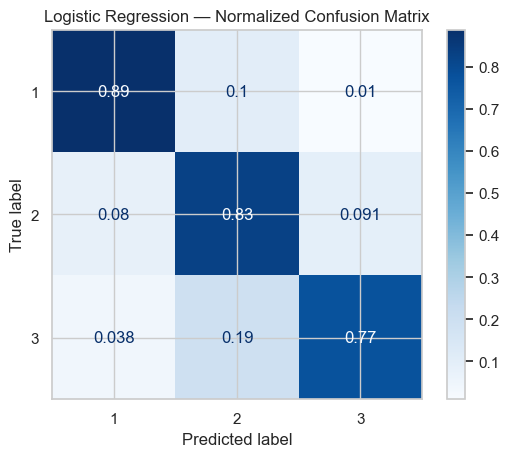

In [202]:
log_reg_pipeline = Pipeline(steps=[

    # Fills any NaN
    ('imputer', SimpleImputer(strategy='median')),

    # Standardise features
    ('scaler', StandardScaler()),

    # Classifier
    ('log_reg', LogisticRegression(

        max_iter=1000,

        # True 3 class softmax
        multi_class='multinomial',

        # Compensate for class imbalance 
        class_weight='balanced',
        solver='lbfgs'
    ))
])
_ = evaluate_model('Logistic Regression', log_reg_pipeline, X_train, y_train, X_test, y_test, display_report=True)

# Analysis of Results

## Normal (1):
### High recall (0.889) & High precision (0.980)

## Suspect (2):
### High recall (0.830) BUT Low precision

## Pathologic (3)
### Moderately high recall (0.774) & Moderately high precision (0.759)
### We feel that due to the severity of identifying pathologic cases, the number should be higher. 

# Analysis of the Confusion Matrix

## Predictions of True 1:
### 1 -> 0.89
### 2 -> 0.1
### 3 -> 0.01

## Predictions of True 2:
### 1 -> 0.08
### 2 -> 0.83
### 3 -> 0.091

## Predictions of True 3
### 1 -> 0.038
### 2 -> 0.19
### 3 -> 0.77


### Based on the results, we can see that there it 19% of pathalogic cases have been identified to be Suspect. This is a false negative of the highest severity as it may identify a fetus that needs immediate medical intervention as simply a borderline case. This will result in the fetus getting late medical attention and reduces the likelihood of this pregnancy getting carried to full term. 

# Decision Tree

## Recursively partitions the feature space with binary questions (ASTV > 75) chosen to maximise class purity (Gini impurity by default)
## Creates a tree structure where each leaf stores the majority class (and probabilities)
## Depth and leaf size control the granualarity of decision rules

## Pros 

### Individual splits map cleanly to clinical huerestics, making the reasoning easy to explain

### Captures non-linear tresholds and feature interations without feature engineering

### No scaling required and robust to monotonic transformations

# Cons

## Overfits if left unchecked; here we regularise with min_samples_leaf

### Small data perturbatuons can reshape the tree (high variance)

### Performance ceiling lower than ensembles due to single-path decisions

Decision Tree — Balanced Accuracy: 0.872, Macro F1: 0.839


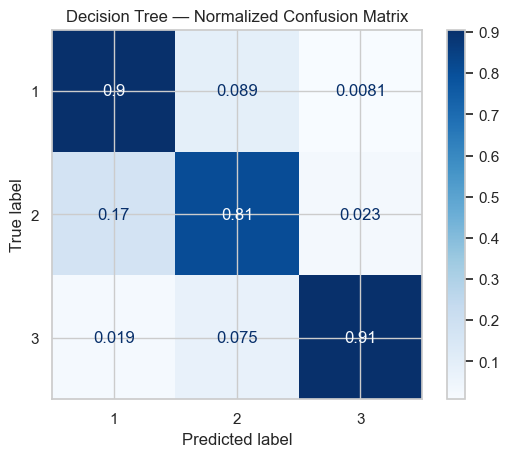

In [213]:
tree_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('tree', DecisionTreeClassifier(
        criterion='gini',
        min_samples_leaf=5,
        max_depth=None,
        class_weight='balanced',
        random_state=42
    ))
])
_ = evaluate_model('Decision Tree', tree_pipeline, X_train, y_train, X_test, y_test)

# Analysis of Confusion Matrix

## Predictions of True 1:
### 1 -> 0.9
### 2 -> 0.089
### 3 -> 0.0081

## Predictions of True 2:
### 1 -> 0.17
### 2 -> 0.81
### 3 -> 0.023

## Predictions of True 3:
### 1 -> 0.019
### 2 -> 0.075
### 3 -> 0.91

### Based on the confusion matrix, I can see that the model finds it confusing to differentiate between Normal and Suspect cases. 17% of predicted Suspect ended up being Normal. I can also see that the model is able to predict pathalogic cases well with an accuracy of 91%. This shows that this is a better model to use compared to logistic regression.

# Random Forest

## Trains many decision trees on bootstrapped samples of the training data and random subsets of features at each split to decorrelate the trees

## Aggregates predictions by majority vote (classification) for robustness

## Feature importance emerges from averaged impurity reduction across trees

## Pros 

### Strong default accuracy on tabular data with minimal tuning

## Handles class imbalance better than a single tree, especially with class weights

## Provides global feature importance for clinician-facing summaries

## Cons

### Harder to interpret individual decisions compared with a single tree

### Larger ensembles increase interference latency and memory footprint

### Can still be biased toward majority class without weighting (addressed here)

Random Forest — Balanced Accuracy: 0.915, Macro F1: 0.911


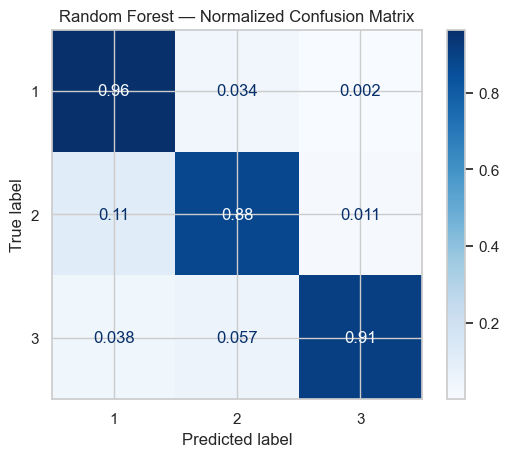

In [221]:
rf_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('rf', RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=4,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])
_ = evaluate_model('Random Forest', rf_pipeline, X_train, y_train, X_test, y_test)

# Analysis of Results

## Predictions of True 1:
### 1 -> 0.96
### 2 -> 0.034
### 3 -> 0.002

## Predictions of True 2:
### 1 -> 0.11
### 2 -> 0.88 
### 3 -> 0.011

## Predictions of True 3:
### 1 -> 0.038
### 2 -> 0.057
### 3 -> 0.91

### This model is able to predict the Normal cases with a high accuracy. The model is also able to predict Pathalogic cases with a high accuracy. This shows that the model is well versed in differentiating between Normal and Pathologic cases.

# Gradient Boosting

## Builds trees sequentially, each new tree focusing on the residual errors of the ensemble-so-far (gradients of the loss). 

## Uses learning rate shrinking so that many small trees collectively approximate complex decision surfaces

## Our scikit-learn implementation optimizes devisance loss for probablistic outputs. 

## Pros

### High accuracy on structured data with modest feature counts

### Naturally highlights hardest-to-classify samples, often imporvong minority-class sensitivity 

### Feature importance and SHAP values can expose nuanaced interactions 

## Cons

### Sensitive to hyperparameters (learning rate, depth, number of estimators)
### Training is sequential, so slower than forests
### Requires careful monitoring for overfitting, especially on small datasets

Gradient Boosting — Balanced Accuracy: 0.911, Macro F1: 0.921


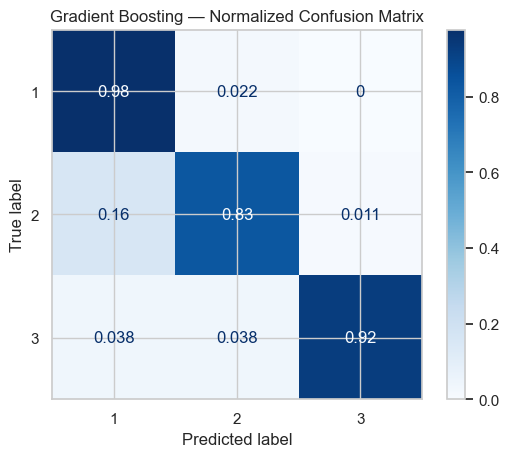

In [232]:
gb_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('gb', GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ))
])
gb_fit_kwargs = {'gb__sample_weight': sample_weight_train}
_ = evaluate_model('Gradient Boosting', gb_pipeline, X_train, y_train, X_test, y_test, fit_kwargs=gb_fit_kwargs)

# Analysis of Results 

## Predictions of True 1:
### 1 -> 0.98
### 2 -> 0.022
### 3 -> 0

## Predictions of True 2:
### 1 -> 0.16
### 2 -> 0.83
### 3 -> 0.011

## Prediction of True 3:
### 1 -> 0.038
### 2 -> 0,038
### 3 -> 0.92

### Gradient boosting has proven to have the highest recall for pathologic cases (92%) thus far and is shown to be able to identify Normal cases (98%) most of the time. It is also to accurately identify suspect cases well (88%)

# Support Vector Machine (SVM)

## Constructs a maximal-margin hyperplane in a transformed feature space; here an RBF kernel lifts data into higher dimensions
## Only support vectors (points near the decision boundary)
## Class weighting shifts the margin to favour recall on minority classes

## Pros

### Excellent at carving clear margins when classes are separable in kernal space
### Effective on medium-sized tabular datasets without extensive tuning
### Margins reduce overfitting in high-dimensional settings

## Cons

### Requires scaled inputs for stable kernel evaluations
### Training time grows quickly with sample size and number of support vectors
### Harder to interpret - kernel trick obscures feature contributions

Support Vector Machine — Balanced Accuracy: 0.857, Macro F1: 0.825


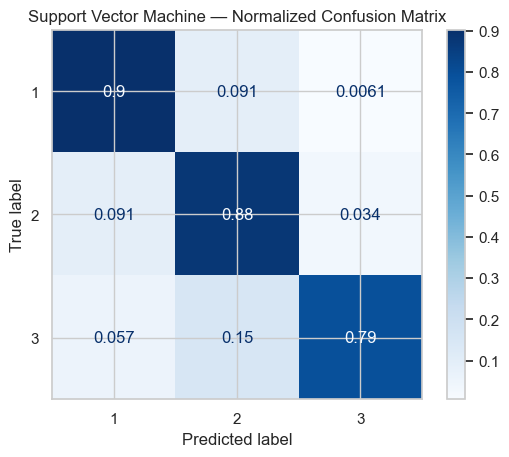

In [271]:
svm_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('svm', SVC(
        kernel='rbf',
        C=2.0,
        gamma='scale',
        class_weight='balanced'
    ))
])
_ = evaluate_model('Support Vector Machine', svm_pipeline, X_train, y_train, X_test, y_test)

# Based on Results:

## Predictions of True 1:
### 1 -> 0.9
### 2 -> 0.091
### 3 -> 0.0061

## Predictions of True 2:
### 1 -> 0.091
### 2 -> 0.88
### 3 -> 0.034

## Prediction of True 3:
### 1 -> 0.057
### 2 -> 0.15
### 3 -> 0.79

### This model is able to predict Normal cases well (90%). However when it is only able to predict 79% of pathalogic cases. 15% of the pathalogic cases are predicted to be Suspect. This is a false negative of the highest severity as it may identify a fetus that needs immediate medical intervention as simply a borderline case. This will result in the fetus getting late medical attention and reduces the likelihood of this pregnancy getting carried to full term. 

# Neural Networks (MLP)

## Stacks fully connected layers; each neuron applies a linear transformation followed by a non-linear activation (ReLU) to learn hierarchical features abstractions.

## Backpropagation adjusts weights to minimize cross-entropy loss, with early stopping preventing overfit. 

## Hidden layers allow complex, non-linear decision boundaries beyong tree ensembles

## Pros

### Flexible function approximator capable of capturing subtle feature interactions
### Early stopping and adaptive learning rate stabilize training on limited data
### Probabilistic outputs suitable for risk stratification tresholds

## Cons

### Acts as a black box; internal representations are difficult to interpret clinically
### Sensitive to feature scaling and weight initialisation
### Overfitting risk on small datasets; requires careful regularsation and monitoring 

Neural Network (MLP) — Balanced Accuracy: 0.801, Macro F1: 0.832


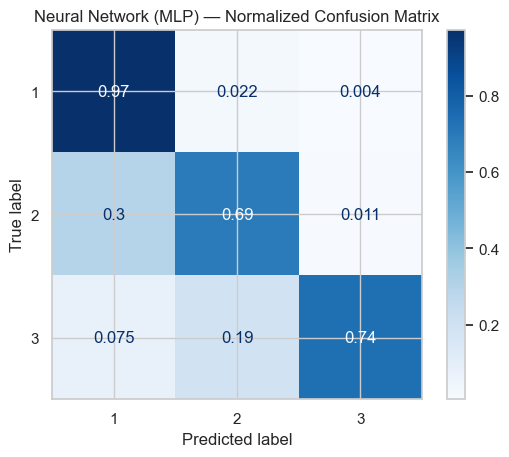

In [243]:
mlp_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        alpha=1e-3,
        learning_rate='adaptive',
        max_iter=1000,
        early_stopping=True,
        random_state=42
    ))
])
_ = evaluate_model('Neural Network (MLP)', mlp_pipeline, X_train, y_train, X_test, y_test)

# Analysis of Results

## Predictions of True 1:
### 1 -> 0.97
### 2 -> 0.022
### 3 -> 0.004

## Predictions of True 2:
### 1 -> 0.3
### 2 -> 0.69
### 3 -> 0.011

## Predictions of True 3:
### 1 -> 0.075
### 2 -> 0.19
### 3 -> 0.74

### The model is able to predict Normal cases (97%) with an extremely high accuracy. However, it is unable to identify Suspect cases (69%) well. Based on the results, we can see that there it 19% of pathalogic cases have been identified to be Suspect. This is a false negative of the highest severity as it may identify a fetus that needs immediate medical intervention as simply a borderline case. This will result in the fetus getting late medical attention and reduces the likelihood of this pregnancy getting carried to full term. 

# k-Nearest Neighbours (kNN)

## Stores the entire training set; to classify a new point, finds the k closest samples (using Euclidean distance after scaling) and assigns the majority label

## No training phase beyong storing data; prediction cost scales with dataset size

## Distance weighing can refine voting, throigh we use uniform weights for clarity

## Pros

### Conceptually intuituve for workshop demos; decision boundary follows the data manifold
### Non-parametric - adapts as more CTG cases are added without retraining
### Performs well when relevant features are well-scaled and informative

## Cons

### Prediction latency grows with dataset size; unsuitable for large real-time deployments 
### Sensitive to noisy features and requires scaling to prevent dominance by high-variance variables
### Choice of k crucial; small k overfits, large k underfits minority classes

k-Nearest Neighbors — Balanced Accuracy: 0.722, Macro F1: 0.771


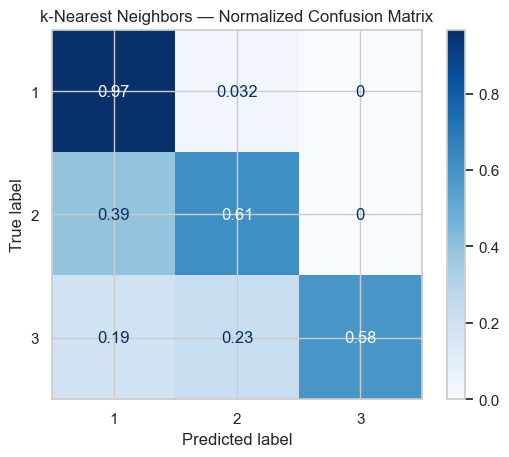

In [253]:
knn_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=15))
])
_ = evaluate_model('k-Nearest Neighbors', knn_pipeline, X_train, y_train, X_test, y_test)

# Analysis of Results

## Predictions of True 1:
### 1 -> 0.97
### 2 -> 0.032
### 3 -> 0

## Predictions of True 2:
### 1 -> 0.39
### 2 -> 0.61
### 3 -> 0

## Predictions of True 3
### 1 -> 0.19
### 2 -> 0.23
### 3 -> 0.58

### Based on the results obtained, we can see that the model is able to identify most of the Normal cases. 

### However, when it comes to the Suspect cases, 39% of the predictions made by the Model identifies a suspect case as Normal. Having a Suspect case categorised as Normal would mean that a fetus that requires monitoring may not be monitored by the doctors as well as they should be. This may lead to the fetus not receiving timely medical attention, increasing the risk of fetal disease or compications during childbirth. 

### The model is only able to identify 58% of the Pathalogic cases. 19% of pathalogic cases are identified to be Normal while 23% of Pathalogic cases are identified to be Suspect. This is highly alarming as it may identify a fetus that needs immediate medical intervention as simply a borderline case or one that requires no medical intervention at all. This will result in the fetus getting late medical attention and reduces the likelihood of this pregnancy getting carried to full term. 

In [279]:
# Aggregate model performance
results_df = pd.DataFrame(results).sort_values('Balanced Accuracy', ascending=False)
results_df.reset_index(drop=True)

results_df = pd.DataFrame(results)
# collapse to one row per model by keeping the last occurrence
results_df = (results_df
              .drop_duplicates(subset=["Model"], keep="last")
              .sort_values("Balanced Accuracy", ascending=False)
              .reset_index(drop=True))
results_df

,Model,Balanced Accuracy,F1 Macro
0,Random Forest,0.91,0.91
1,Gradient Boosting,0.91,0.92
2,Decision Tree,0.87,0.84
3,Support Vector Machine,0.86,0.83
4,Logistic Regression,0.83,0.79
5,Neural Network (MLP),0.80,0.83
6,k-Nearest Neighbors,0.72,0.77


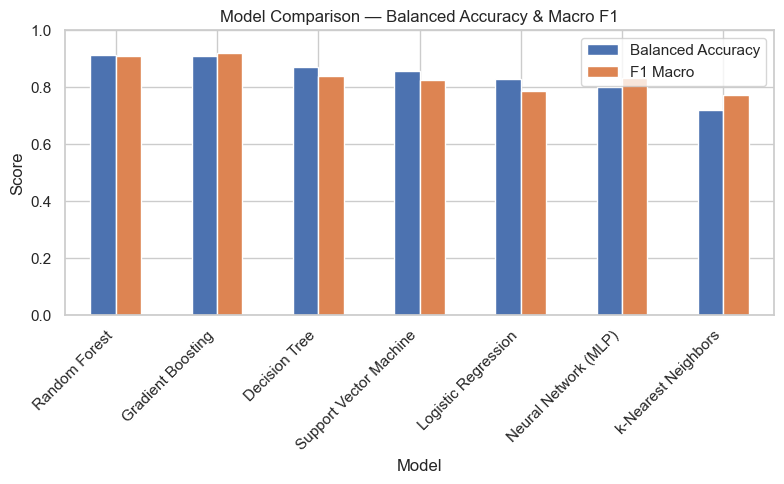

In [281]:
# Visual comparison
fig, ax = plt.subplots(figsize=(8, 5))
results_df.plot(x='Model', y=['Balanced Accuracy', 'F1 Macro'], kind='bar', ax=ax)
ax.set_ylim(0, 1)
ax.set_ylabel('Score')
ax.set_title('Model Comparison — Balanced Accuracy & Macro F1')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Based on all the results, we believe that Gradient Boosting is the best model for this dataset. It has the highest balanced accuracy and F1 Macro. 

## We have the trained model for Gradient Boosting. 

Gradient Boosting — Balanced Accuracy: 0.911, Macro F1: 0.921


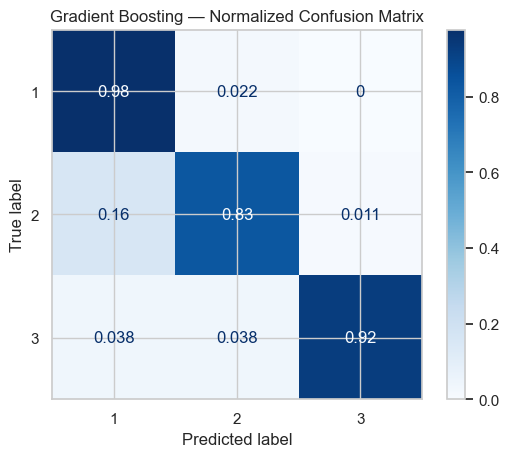

In [287]:
gb_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('gb', GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ))
])
gb_fit_kwargs = {'gb__sample_weight': sample_weight_train}
_ = evaluate_model('Gradient Boosting', gb_pipeline, X_train, y_train, X_test, y_test, fit_kwargs=gb_fit_kwargs)


## Retrain Gradient Boosting on the full dataset

In [291]:
# Combine full dataset
X_full = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

# Retrain final model on all available data
gb_final = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('gb', GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ))
])

# Fit on the full data
gb_final.fit(X_full, y_full)


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('gb',
                 GradientBoostingClassifier(learning_rate=0.05,
                                            n_estimators=300,
                                            random_state=42))])

In [293]:
# Make predictions
predictions = gb_final.predict(X_full)

# Or get probabilities (e.g., for risk scoring)
probabilities = gb_final.predict_proba(X_full)


In [295]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_full, predictions))
print(confusion_matrix(y_full, predictions))


              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1647
           2       0.99      0.99      0.99       293
           3       1.00      1.00      1.00       175

    accuracy                           1.00      2115
   macro avg       0.99      1.00      1.00      2115
weighted avg       1.00      1.00      1.00      2115

[[1643    4    0]
 [   3  290    0]
 [   0    0  175]]


## This model is able to able to distinguish between the Normal, Suspect and Pathologic cases with close to a 100% accuracy. For Suspect cases it has a precision of 99%. The error is negligible due to the sample being borderline. The macro average is 0.99-1.00 which indicates that there is no bias towards any of the classes. The weighted average is 1.00 which indicates that there is consistent performance across class sizes. 

## Breakdown of the Confusion Matrix:

## Class 1 -> 4 of the Normal cases have been identified as Suspect
## Class 2 -> 3 of the Suspect cases have been identified as Normal
## Class 3 -> All of the pathologic cases have been identified accurately 

# In the medical context, the most important feature that the model should have is to ensure that pathalogic cases have been identified with the highest accuracy. Looking at the results of our model, we can see that our model is able to predict pathalogic cases with a 100% accuracy. This shows incredible clinical reliability and would ensure that every pathalogic case will be able to receive timely medical intervention, significantly helping to lower the rate of fetal diseases and complications during pregnancy and childbirth. 

In [297]:
import joblib
joblib.dump(gb_final, 'final_gradient_boosting_model.pkl')


['final_gradient_boosting_model.pkl']

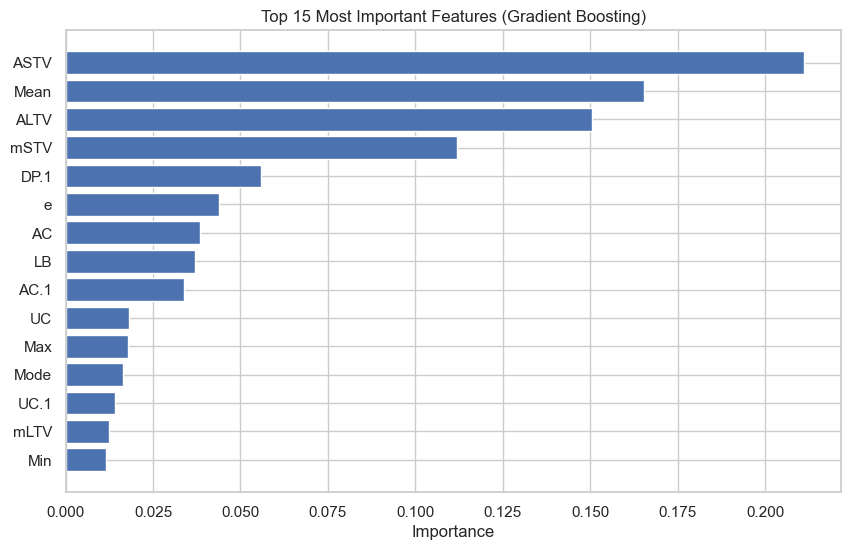

In [299]:
import matplotlib.pyplot as plt
import numpy as np

importances = gb_final.named_steps['gb'].feature_importances_
indices = np.argsort(importances)[::-1]
features = X_full.columns

plt.figure(figsize=(10,6))
plt.barh(features[indices][:15][::-1], importances[indices][:15][::-1])
plt.title('Top 15 Most Important Features (Gradient Boosting)')
plt.xlabel('Importance')
plt.show()
